<a href="https://colab.research.google.com/github/bernieee/SIRIUS/blob/master/AI_for_Med_image_analysis/Challenge_lungs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir data64 
!unzip /content/drive/My\ Drive/data64.zip -d data64

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib import image as IMG
import imageio
from PIL import Image
import torchvision as tv
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale, resize, downscale_local_mean
from pathlib import Path

In [4]:
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [5]:
images_path = 'data64/data64'
labels_path = '/content/drive/My Drive/train_new.csv'
test_path = '/content/drive/My Drive/test_new.csv'

## **Prepare train data**

In [6]:
train_df = pd.read_csv(labels_path)
#train_df

In [7]:
frontal = list(map(str, train_df[train_df['label']=='frontal']['target_name'])) 
lateral = list(map(str, train_df[train_df['label']=='lateral']['target_name']))

In [8]:
images = np.concatenate([frontal, lateral])
image_names = []
image_labels = {}

for image in images:
    image_name = images_path + '/' + image
    if image in frontal:
        image_labels.update({image_name: 1})
    else:
        image_labels.update({image_name: 0})
    image_names.append(image_name)

In [9]:
##SERGE

resized_images = {}

for image_name in image_names:
    resized_images[image_name] = np.asarray(Image.open(image_name).convert("L")) / 256

(64, 64)


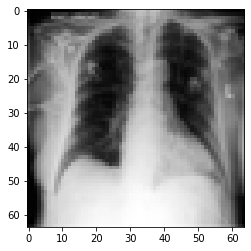

In [10]:
for i, k in enumerate(resized_images):
    if i == 0:
        print(resized_images[k].shape)
        plt.imshow(resized_images[k], cmap='gray')
        break

In [11]:
##SERGE

class LungsClassificationDataset(Dataset):
    def __init__(self, image_names, resized_images, image_labels):
        self.image_names = image_names
        self.resized_images = resized_images
        self.image_labels = image_labels
                                            
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index):
        image_path = self.image_names[index]

        image_0 = self.resized_images[image_path]
        label = self.image_labels[image_path]

        image = torch.tensor(image_0)
        label = torch.tensor(label)
  
        return {'image':image, 'label':label}

In [12]:
train_image_names, val_image_names = train_test_split(image_names, test_size=0.2)

train = LungsClassificationDataset(train_image_names, resized_images, image_labels)
validation = LungsClassificationDataset(val_image_names, resized_images, image_labels)

In [13]:
imageWidth, imageHeight = train[0]['image'].shape

tensor(0)


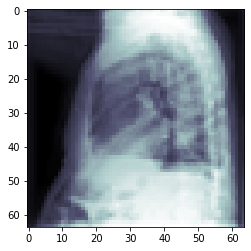

In [15]:
sample = train[5]
plt.imshow(sample['image'], cmap='bone')
print(sample['label'])

## **Model Architecture**

In [14]:
class LungModel(nn.Module):
    def __init__(self,width,height): 
        super(LungModel,self).__init__()  

        numConvs1 = 8
        numConvs2 = 16
        numConvs3 = 32
        numConvs4 = 64
        numConvs5 = 256
        convSize = 3
       
        self.cnv1 = nn.Conv2d(in_channels=1, out_channels=numConvs1, kernel_size=convSize)
        self.cnv2 = nn.Conv2d(in_channels=numConvs1, out_channels=numConvs2, kernel_size=convSize)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv3 = nn.Conv2d(in_channels=numConvs2, out_channels=numConvs3, kernel_size=convSize)
        self.cnv4 = nn.Conv2d(in_channels=numConvs3, out_channels=numConvs4, kernel_size=convSize)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2d = nn.Dropout2d(0.25)
        self.cnv5 = nn.Conv2d(in_channels=numConvs4, out_channels=numConvs4, kernel_size=convSize)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        denseSize1 = 512
        denseSize2 = 100
      
        self.dense1 = nn.Linear(64*13*13, denseSize1)
        self.dense2 = nn.Linear(denseSize1, denseSize2)
        self.dense3 = nn.Linear(denseSize2, 1)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):

        #print(self.cnv1(x).shape)
        x = F.elu(self.cnv1(x))
        x = F.elu(self.cnv2(x))
        #print(self.maxpool1(x).shape)
        x = self.maxpool1(x)
        #x = self.dropout2d(x)
        #print(self.cnv2(x).shape)
        x = F.elu(self.cnv3(x))
        x = F.elu(self.cnv4(x))
        #print(self.maxpool2(x).shape)
        x = self.maxpool2(x)
        #print(self.dropout2d(x).shape)
        #x = self.dropout2d(x)
        #x = F.elu(self.cnv5(x))
        #print(self.maxpool3(x).shape)
        #x = self.maxpool3(x)
        x = x.view(-1,self.num_flat_features(x))
        #print(self.dense1(x).shape)
        x = F.elu(self.dense1(x)) 
        x = self.dropout(x)
        x = F.elu(self.dense2(x)) 
        x = self.dropout(x)
        x = self.dense3(x)        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [15]:
model = LungModel(imageWidth, imageHeight).to(dev)

In [16]:
train_loader = DataLoader(train, batch_size=50, shuffle=True, drop_last=True)
val_loader = DataLoader(validation, batch_size=50, shuffle=True, drop_last=True)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [18]:
import time
print(time.time())

1596525071.082724


In [19]:
num_epochs = 10

t = time.time() 

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    time_start = time.time()

    for sample_idx, sample in enumerate(train_loader):
        image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
        image, label = image.to(dev), label.to(dev)

        prediction = model(image)

        optimizer.zero_grad()
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step() 

        train_loss += loss.item()

        if sample_idx % 100 == 0:
            print(loss.item())

    val_loss = 0
    model.eval()

    with torch.no_grad():
        for sample in val_loader:
            image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
            image, label = image.to(dev), label.to(dev)
            prediction = model(image)

            optimizer.zero_grad()
            loss = criterion(prediction, label)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch: {epoch}; Time Epoch: {time.time() - time_start}\nTraining Loss: {train_loss}\nValidation Loss: {val_loss}\n-----")


0.6911119222640991
Epoch: 0; Time Epoch: 1.8550136089324951
Training Loss: 0.15930752211716026
Validation Loss: 0.050114484426255025
-----
0.02743666060268879
Epoch: 1; Time Epoch: 1.522911548614502
Training Loss: 0.04703667192427697
Validation Loss: 0.04561674090412756
-----
0.018402099609375
Epoch: 2; Time Epoch: 1.5204384326934814
Training Loss: 0.04168301416497093
Validation Loss: 0.037790510221384466
-----
0.16761092841625214
Epoch: 3; Time Epoch: 1.518261194229126
Training Loss: 0.02911968878926892
Validation Loss: 0.031118406642538805
-----
0.0010087683331221342
Epoch: 4; Time Epoch: 1.516425609588623
Training Loss: 0.02272742519362866
Validation Loss: 0.023163561777134117
-----
0.005378338508307934
Epoch: 5; Time Epoch: 1.5226764678955078
Training Loss: 0.018987655199096336
Validation Loss: 0.0206305871057945
-----
0.01706530712544918
Epoch: 6; Time Epoch: 1.528703212738037
Training Loss: 0.011069613585349027
Validation Loss: 0.032649233187839855
-----
0.0006005359464325011
Epo

## **Prepare test data**

In [58]:
test_df = pd.read_csv(test_path)
test_df

,Unnamed: 0,target_name
0,0,patient00012study2view2.png
1,1,patient00016study1view2.png
2,2,patient00023study2view2.png
3,3,patient00023study9view2.png
4,4,patient00080study7view2.png
...,...,...
795,795,patient03368study1view2.png
796,796,patient01121study6view1.png
797,797,patient00480study12view1.png
798,798,patient06861study1view1.png


In [59]:
images = list(map(str, test_df['target_name']))
test_image_names = []

for image in images:
    image_name = images_path + '/' + image
    test_image_names.append(image_name)

In [22]:
nTestData = len(test_image_names)

In [60]:
##SERGE

resized_images = {}

for image_name in test_image_names:
    resized_images[image_name] = np.asarray(Image.open(image_name).convert("L")) / 256

(64, 64)


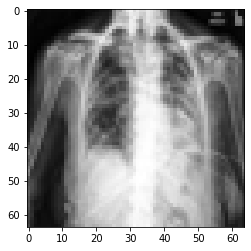

In [29]:
for i, k in enumerate(resized_images):
    if i == 0:
        print(resized_images[k].shape)
        plt.imshow(resized_images[k], cmap='gray')
        break

In [42]:
model(torch.tensor(resized_images[test_image_names[0]]).unsqueeze(0).unsqueeze(0).float().to(dev))

tensor([[14.4084]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
correct = 0
total = 0
ans = []

model.eval()

with torch.no_grad():
    for k in resized_images:
        image = torch.tensor(resized_images[k]).unsqueeze(0).unsqueeze(0).float()
        image = image.to(dev)
        prediction = model(image)
        prediction = torch.sigmoid(prediction)

        ans.append(prediction.item())
        print(prediction.item())                    

In [62]:
test_df.insert(1, 'label', ans)

In [63]:
test_df

,Unnamed: 0,label,target_name
0,0,6.294166e-14,patient00012study2view2.png
1,1,5.830955e-13,patient00016study1view2.png
2,2,7.061686e-14,patient00023study2view2.png
3,3,7.828312e-15,patient00023study9view2.png
4,4,8.405668e-01,patient00080study7view2.png
...,...,...,...
795,795,1.000000e+00,patient03368study1view2.png
796,796,9.999998e-01,patient01121study6view1.png
797,797,1.000000e+00,patient00480study12view1.png
798,798,9.999989e-01,patient06861study1view1.png


In [64]:
test_df.to_csv(r'ans_csv.csv')